<a href="https://colab.research.google.com/github/felipeescallon/TensorFlow-TPU-vs-GPU/blob/main/Copia_de_GPU_vs_TPU_(TPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuration
## 1.1 Define some constants 

In [1]:
GCS_PATH = 'gs://tf-everywhere-col'
DATASET_NAME = 'rock_paper_scissors'
BATCH_SIZE = 128
NUM_CLASSES = 3
DENSE_UNITS = 128
DROPOUT = 0.4

## 1.2 Authenticate

Authenticates the Colab machine and the TPU using your credentials so you can access the private GCS bucket.

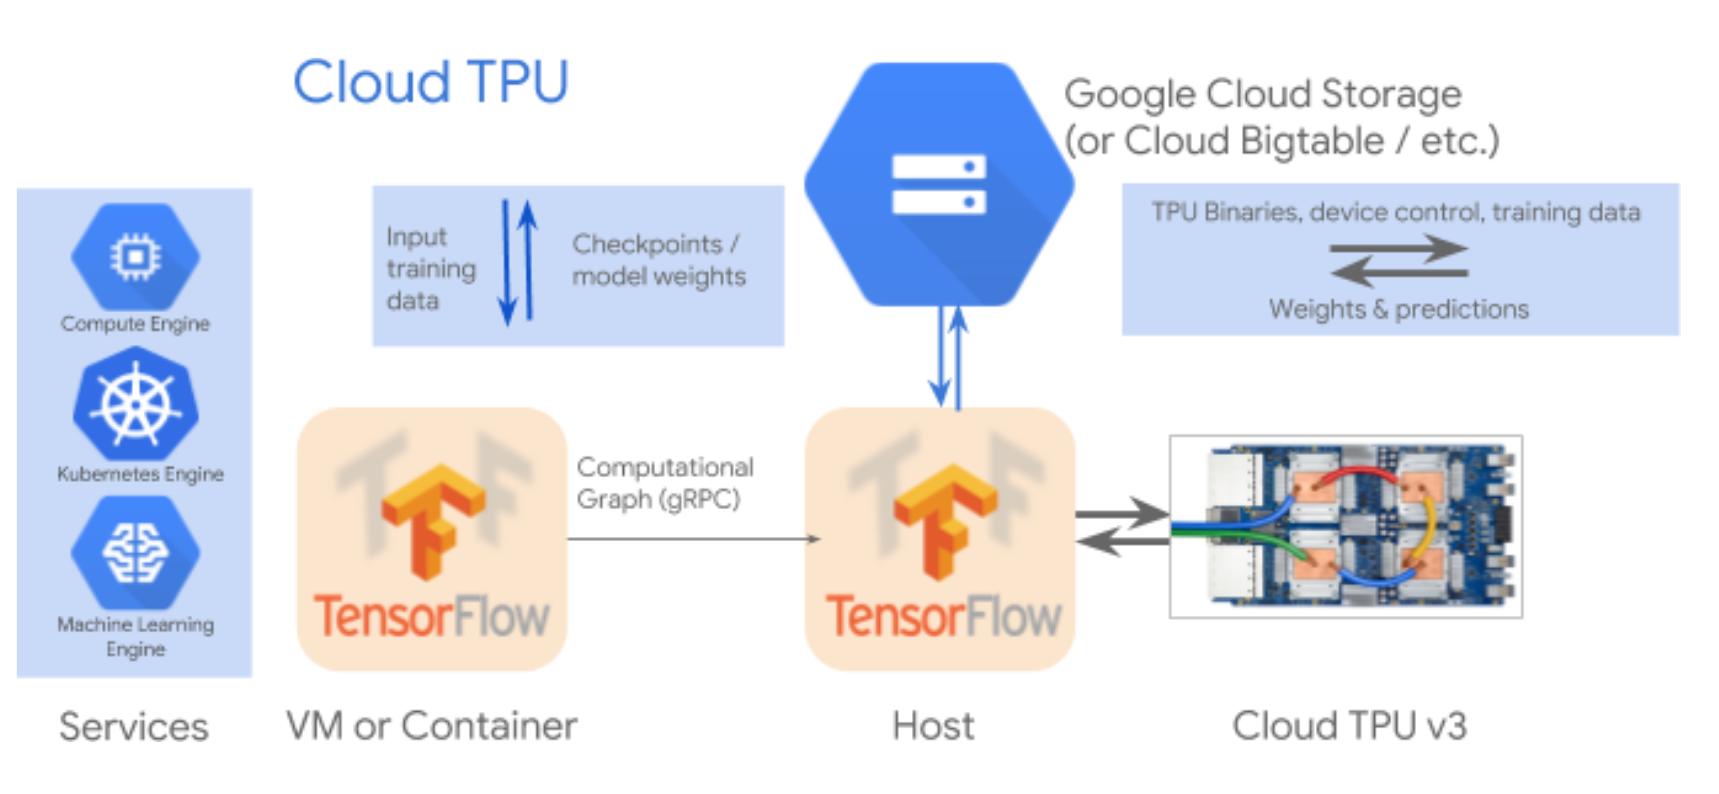

In [2]:
from google.colab import auth


auth.authenticate_user()

## 1.3 Setup TPU

In [3]:
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers, callbacks
from datetime import datetime

     |████████████████████████████████| 706kB 6.2MB/s 


In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.75.133.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.133.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# 2. Dataset definition

In [5]:
train_ds, train_ds_info = tfds.load(DATASET_NAME, 
                                    split="train", 
                                    with_info=True, 
                                    shuffle_files=True,
                                    data_dir=f'{GCS_PATH}/{DATASET_NAME}/train')
val_ds, val_ds_info = tfds.load(DATASET_NAME, 
                                split="test",
                                with_info=True, 
                                shuffle_files=False, 
                                data_dir=f'{GCS_PATH}/{DATASET_NAME}/val')

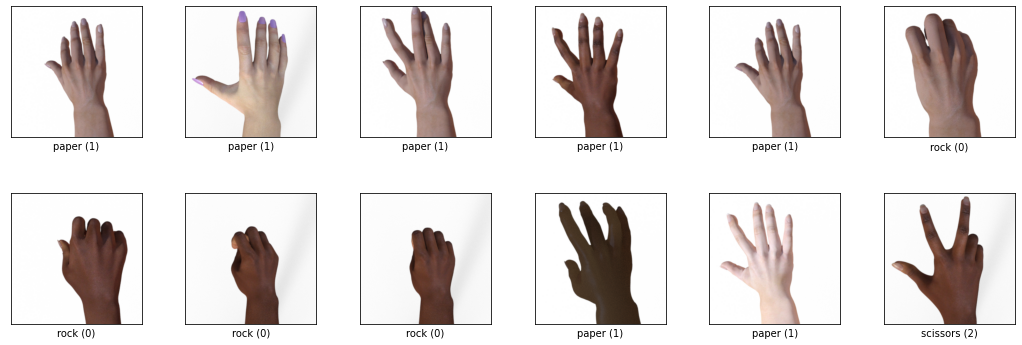

In [6]:
tfds.visualization.show_examples(train_ds, train_ds_info, rows=2, cols=6);

## 2.1 Data Preprocessing

In [7]:
from tensorflow.data.experimental import AUTOTUNE

@tf.function
def preprocess(example, height=224, width=224):
    image = example['image']
    label = example['label']
    image = tf.image.resize_with_crop_or_pad(image, height, width)
  
    image = tf.keras.applications.resnet.preprocess_input(image)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image,label

def get_datasets(train_ds, val_ds, batch_size):
    norm_train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)\
            .shuffle(500).batch(batch_size).prefetch(AUTOTUNE)
    norm_val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)\
            .batch(batch_size).cache()
    return norm_train_ds, norm_val_ds

## 2.3 Create train/val datasets

Note the number of replicas is  **8** then we need to multiply the original batch size with the number of replicas, to optimize the usage or the TPU.

In [8]:
norm_train_ds, norm_val_ds = get_datasets(train_ds, val_ds, 
                              batch_size=strategy.num_replicas_in_sync*BATCH_SIZE)

strategy.num_replicas_in_sync

8

# 3. Model definition

In [9]:
def create_model(num_classes, units, dropout):

  input_layer = layers.Input(shape=(224,224,3))

  feature_extractor = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)
  feature_extractor.trainable = False

  features = layers.GlobalAveragePooling2D()(feature_extractor.output)
  x = layers.Dense(units, 'relu')(features)
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(num_classes, 'softmax', dtype='float32')(x)

  model = Model(inputs=[input_layer], outputs=[x], name='feature_extractor')
  model.summary()
  return model

## 3.1 Create & Compile
Using the TPU distribution strategy create and compile the model

In [10]:
with strategy.scope():
    model = create_model(NUM_CLASSES, DENSE_UNITS, DROPOUT)
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')])

94773248/94765736 [==============================] - 1s 0us/step
Model: "feature_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________

## 3.2 Train & Validate model

In [11]:
%%time
history = model.fit(norm_train_ds, validation_data=norm_val_ds, epochs=20)

Epoch 1/20
3/3 [==============================] - 25s 6s/step - loss: 2.0653 - categorical_accuracy: 0.3231 - f1_score: 0.2970 - val_loss: 0.9994 - val_categorical_accuracy: 0.5430 - val_f1_score: 0.5101
Epoch 2/20
3/3 [==============================] - 2s 705ms/step - loss: 1.0916 - categorical_accuracy: 0.5342 - f1_score: 0.4998 - val_loss: 0.8541 - val_categorical_accuracy: 0.7392 - val_f1_score: 0.7071
Epoch 3/20
3/3 [==============================] - 2s 693ms/step - loss: 0.8546 - categorical_accuracy: 0.7011 - f1_score: 0.6780 - val_loss: 0.8988 - val_categorical_accuracy: 0.6586 - val_f1_score: 0.6071
Epoch 4/20
3/3 [==============================] - 2s 670ms/step - loss: 0.7435 - categorical_accuracy: 0.8279 - f1_score: 0.8261 - val_loss: 0.8287 - val_categorical_accuracy: 0.7070 - val_f1_score: 0.6482
Epoch 5/20
3/3 [==============================] - 2s 683ms/step - loss: 0.6876 - categorical_accuracy: 0.8877 - f1_score: 0.8872 - val_loss: 0.8981 - val_categorical_accuracy: 0.